In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install imantics --quiet

  Preparing metadata (setup.py) ... done


In [4]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

In [5]:
images_dir ='/content/drive/MyDrive/Data/train/image'
masks_dir = '/content/drive/MyDrive/Data/train/mask'

In [6]:
images_listdir = os.listdir(images_dir)
masks_listdir = os.listdir(masks_dir)
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [7]:
print(len(images_listdir))
print(len(masks_listdir))

80
80


In [8]:
image_size=512
input_image_size=(512,512)

In [9]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [10]:
number=200

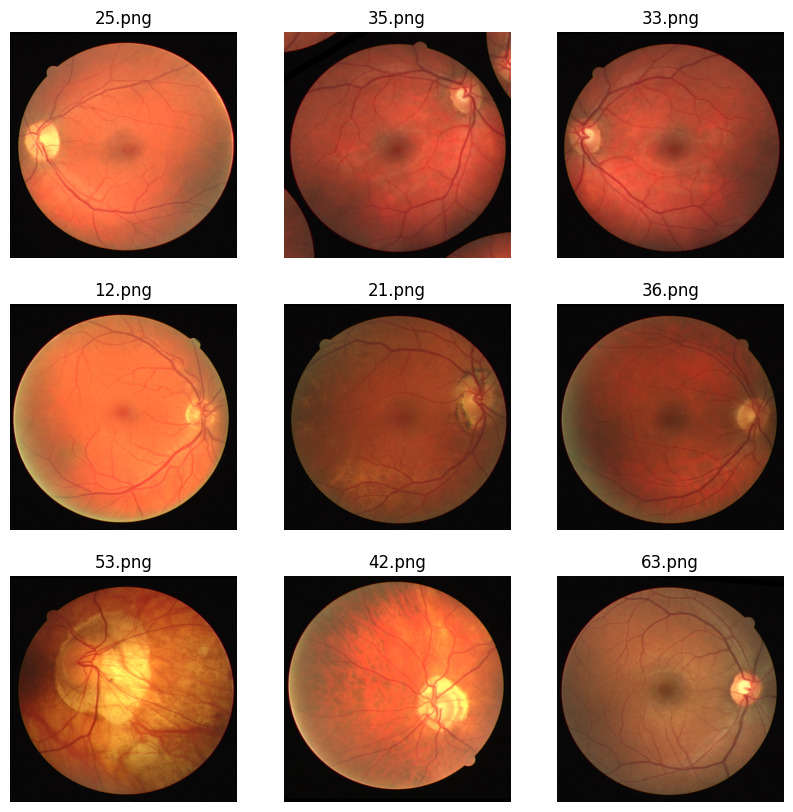

In [11]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

GROUND TRUTH MARKS

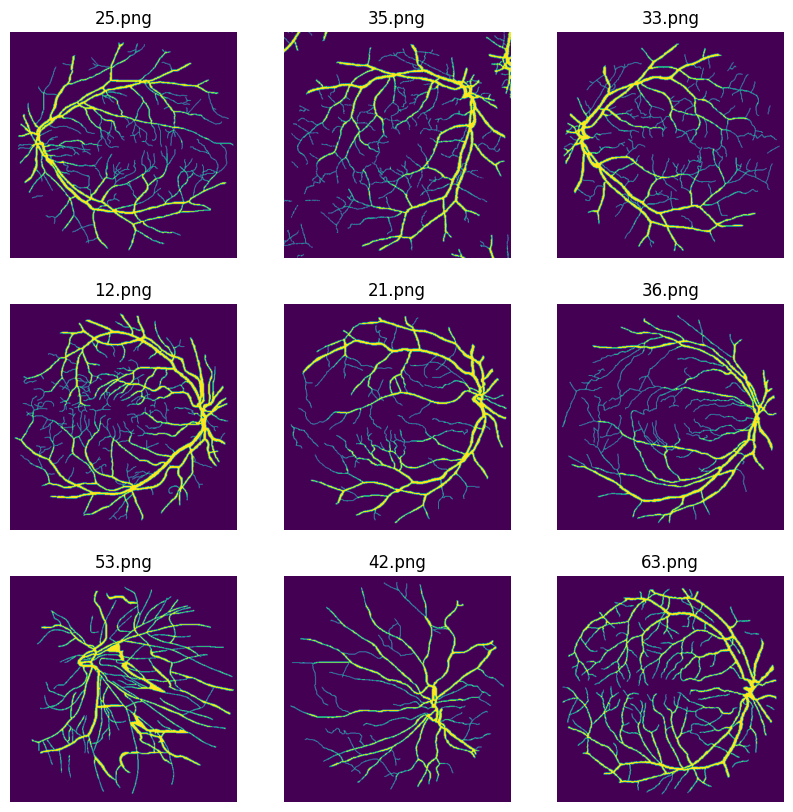

In [12]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [13]:
MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:number]):   ##the smaller, the faster
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        mask = read_image(f"{masks_dir}/{file}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

In [14]:
images=np.array(IMAGES)[1:number+1]
masks=np.array(MASKS)[1:number+1]
print(images.shape,masks.shape)

(80, 512, 512, 3) (80, 512, 512, 1)


In [15]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.4, random_state=42)

In [16]:
print(len(images_train), len(masks_train))

48 48


In [5]:
from __future__ import division
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Dropout # Removed 'core' import
#from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from tensorflow.keras.utils import plot_model as plot
#from keras.optimizers import SGD
from keras.optimizers import *
from keras.layers import *
import numpy as np
from keras.applications.vgg16 import VGG16
import keras

# ... (rest of your code)

!pip install pydot
!pip install graphviz
# Install required libraries for visualization
from tensorflow.keras.utils import plot_model as plot # Import plot_model from the correct module

# ... (rest of your code)


def BCDU_net_D3(input_size = (256,256,3)):
    N = input_size[0]
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)

    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1)
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)

    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1)
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)

    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1)
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)

    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs, conv9)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

def BCDU_net_D1(input_size = (256,256,1)):
    N = input_size[0]
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)

    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_1)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1)
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)

    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1)
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)

    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1)
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)

    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model( inputs,  conv9)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model


def unet(input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
    merge6 = concatenate([drop3,up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv2,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv1,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model( inputs, conv9)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

def SqueezeExcite(x, ratio=16):
    nb_chan = K.int_shape(x)[-1]

    y = GlobalAveragePooling2D()(x)
    y = Dense(nb_chan // ratio, activation='relu')(y)
    y = Dense(nb_chan, activation='sigmoid')(y)

    y = Multiply()([x, y])
    return y

WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.1/'
                       'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

def SEDU_Net_D3(input_size = (256,256,1), learning_rate = 1e-4):
    img_input = Input(input_size)
    N = input_size[0]
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    conv1 = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(conv1)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(pool1)
    conv2 = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    pool2 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(conv2)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(pool2)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    conv3 = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    pool3 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(conv3)
    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(pool3)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    # D1
    drop4_1 = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    # D2
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)

    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = SqueezeExcite(up6, ratio=16)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(conv3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1)
    merge6 = ConvLSTM2D(filters = 256, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)

    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = SqueezeExcite(conv6, ratio=16)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = SqueezeExcite(up7, ratio=16)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1)
    merge7 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)

    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = SqueezeExcite(conv7, ratio=16)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = SqueezeExcite(up8, ratio=16)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1)
    merge8 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)

    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = SqueezeExcite(conv8, ratio=16)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    # Load weights.
    weights_path = keras.utils.get_file(
                   'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                   WEIGHTS_PATH_NO_TOP,
                   cache_subdir='models',
                   file_hash='6d6bbae143d832006294945121d1f1fc')
    model = Model(input = img_input, output = conv9)
    model.load_weights(weights_path, by_name=True)

    model.compile(optimizer = Adam(lr = learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model



In [11]:
# Assuming 'images_train', 'masks_train', 'images_test', and 'masks_test'
# are NumPy arrays or TensorFlow tensors that hold your data, you need to
# define them before using them.
# Example placeholder - replace with your actual data loading logic
images_train = "/content/drive/MyDrive/Data/train/image"
masks_train = "/content/drive/MyDrive/Data/train/mask"
images_test = "/content/drive/MyDrive/Data/test/image"
masks_test = "/content/drive/MyDrive/Data/test/mask"

models = [BCDU_net_D3, BCDU_net_D1, unet, SEDU_Net_D3]
image_size = 256  # Define the image size here. Adjust as needed.
for model_func in models:
    print(f"Training model: {model_func.__name__}")
    model = model_func(input_size=(image_size, image_size, 3))  # Adjust input size if needed
    model.fit(images_train, masks_train,
              validation_data=(images_test, masks_test),
              epochs=1,
              batch_size=4)
    print("-" * 30)  # Separator between model training outputs

Training model: BCDU_net_D3


IndexError: tuple index out of range

TRAIN

In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras import backend as K

# def iou(y_true, y_pred):
#     def f(y_true, y_pred):
#         intersection = (y_true * y_pred).sum()
#         union = y_true.sum() + y_pred.sum() - intersection
#         x = (intersection + 1e-15) / (union + 1e-15)
#         x = x.astype(np.float32)
#         return x
#     return tf.numpy_function(f, [y_true, y_pred], tf.float32)

# smooth = 1e-15
# def dice_coef(y_true, y_pred):
#     y_true = tf.keras.layers.Flatten()(y_true)
#     y_pred = tf.keras.layers.Flatten()(y_pred)
#     intersection = tf.reduce_sum(y_true * y_pred)
#     return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# def dice_loss(y_true, y_pred):
#     return 1.0 - dice_coef(y_true, y_pred)


In [ ]:
import tensorflow as tf

# ... (rest of the code remains the same)

ensemble_result = ensemble_model.fit(
    images_train.astype('float32') / 255.0,  # Normalize and convert to float32
    masks_train,
    validation_split = 0.2, batch_size = 4, epochs = 1)

TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "<ipython-input-25-44926a6b0343>", line 12, in dice_loss  *
        return 1 - dice_coefficient(y_true, y_pred)
    File "<ipython-input-25-44926a6b0343>", line 7, in dice_coefficient  *
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)

    TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type uint8 of argument 'x'.


In [ ]:
def show_result(idx, og, unet, target, p):

    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')

    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet)
    axs[1].axis('off')

    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [ ]:
unet_predict = unet_model.predict(images_test)

1/1 [==============================] - 312s 312s/step


In [ ]:
len(images_test)

32

In [ ]:
r1,r2,r3,r4=0.7,0.8,0.9,0.99

In [ ]:
unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)

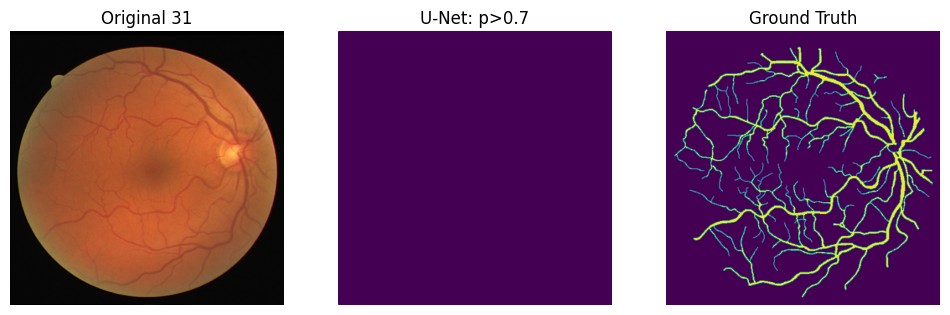

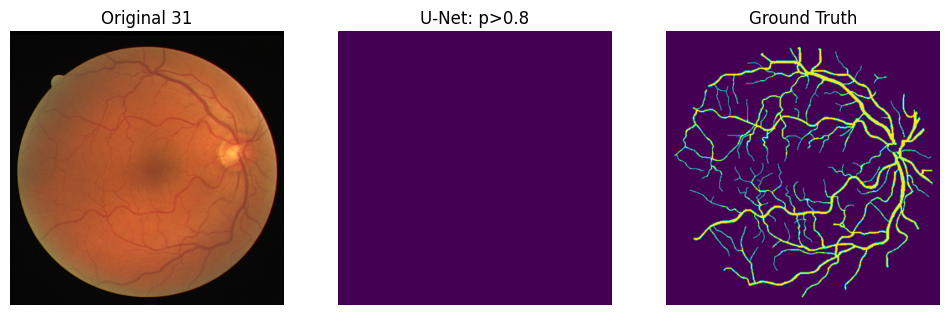

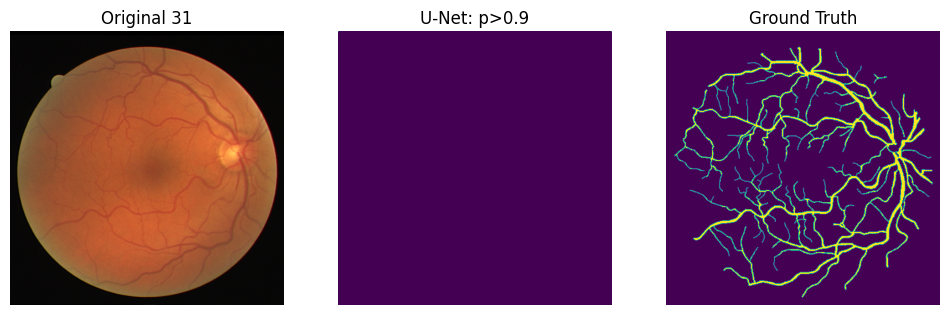

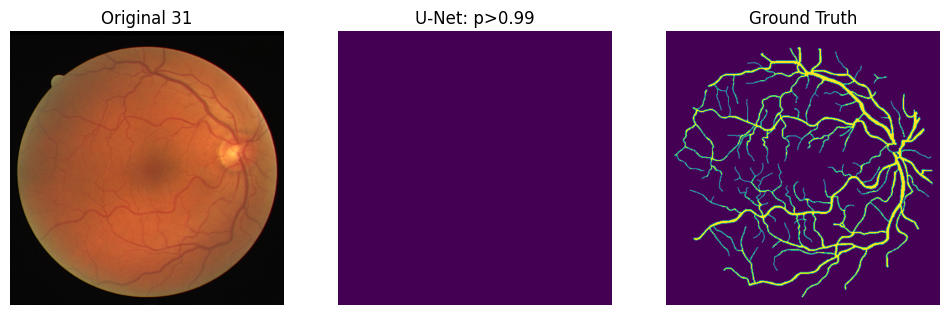

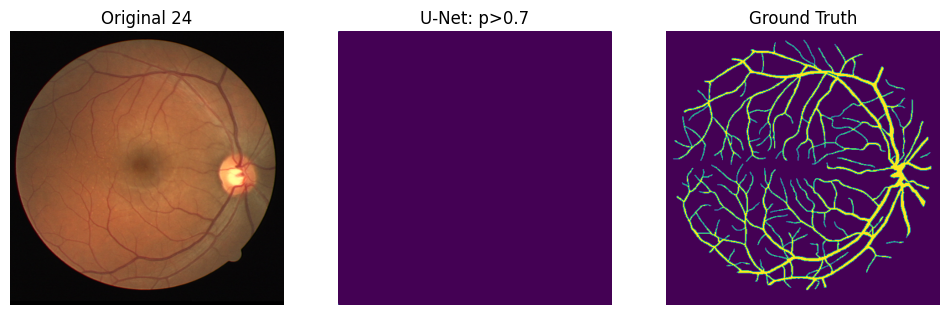

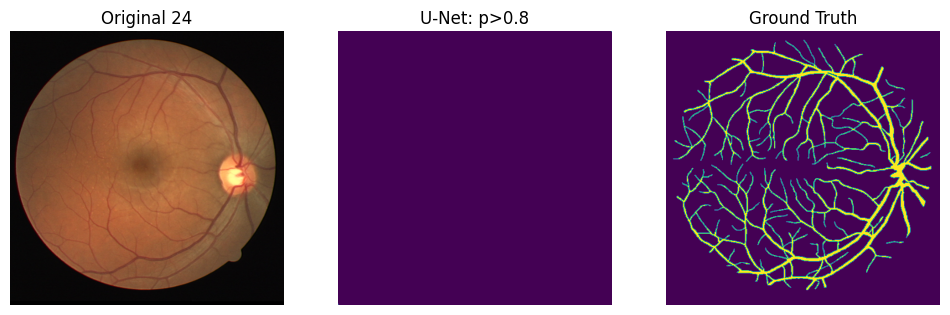

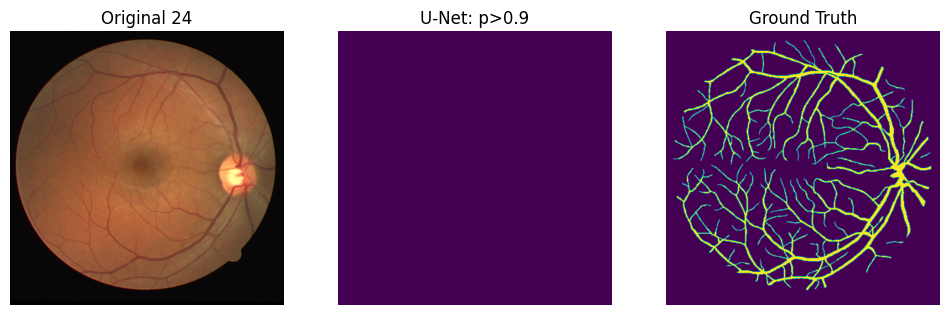

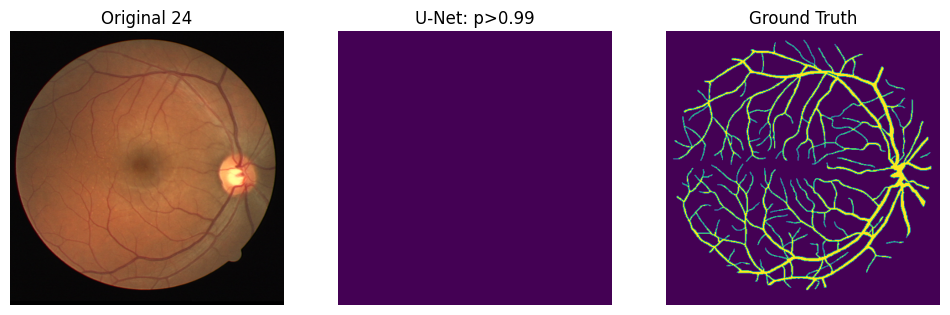

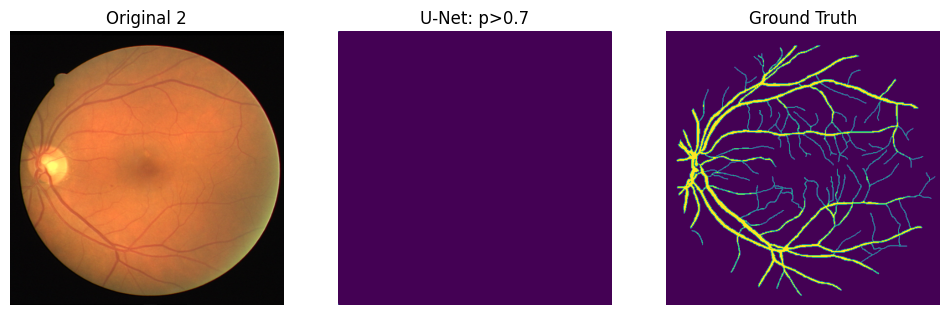

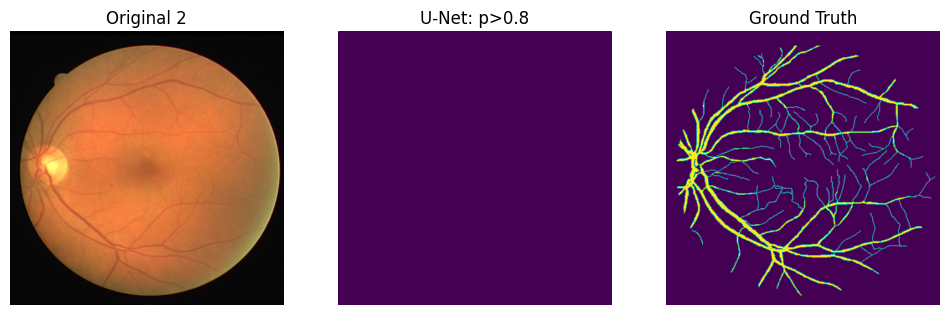

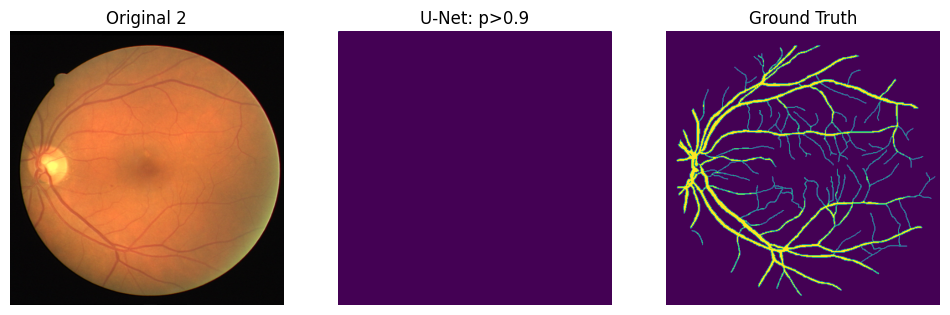

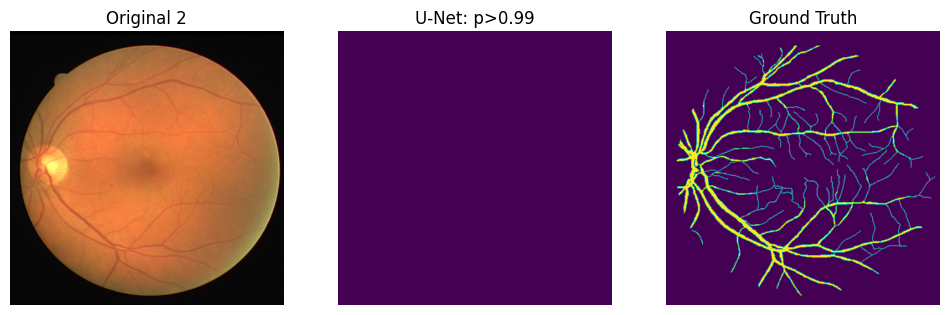

In [ ]:
show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx:
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)
    print()

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Data/test/image/16.png
/content/drive/MyDrive/Data/test/image/1.png
/content/drive/MyDrive/Data/test/image/15.png
/content/drive/MyDrive/Data/test/image/14.png
/content/drive/MyDrive/Data/test/image/11.png
/content/drive/MyDrive/Data/test/image/17.png
/content/drive/MyDrive/Data/test/image/18.png
/content/drive/MyDrive/Data/test/image/12.png
/content/drive/MyDrive/Data/test/image/0.png
/content/drive/MyDrive/Data/test/image/10.png
/content/drive/MyDrive/Data/test/image/13.png
/content/drive/MyDrive/Data/test/image/4.png
/content/drive/MyDrive/Data/test/image/7.png
/content/drive/MyDrive/Data/test/image/2.png
/content/drive/MyDrive/Data/test/image/9.png
/content/drive/MyDrive/Data/test/image/3.png
/content/drive/MyDrive/Data/test/image/6.png
/content/drive/MyDrive/Data/test/image/5.png
/content/drive/MyDrive/Data/test/image/8.png
/content/drive/MyDrive/Data/test/image/19.png
/content/drive/MyDrive/Data/test/mask/17.png
/content/drive/MyDrive/Data/test/mask/12.png


In [ ]:
from keras.utils import normalize
import os
import cv2 as cv
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
image_directory_train="/content/drive/MyDrive/Data/train/image"
mask_directory_train="/content/drive/MyDrive/Data/train/mask"
image_directory_test="/content/drive/MyDrive/Data/test/image"
mask_directory_test="/content/drive/MyDrive/Data/test/mask"

In [ ]:
SIZE = 256
train_image_dataset = []
train_mask_dataset = []
test_image_dataset = []
test_mask_dataset = []

In [ ]:
train_images = os.listdir(image_directory_train)

In [ ]:
for i, image_name in enumerate(train_images):
    if (image_name.split('.')[1] == 'png'):
#         print(image_directory_train+"/"+image_name)
        image = cv.imread(image_directory_train+"/"+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        train_image_dataset.append(np.array(image))

In [ ]:
train_masks = os.listdir(mask_directory_train)
for i, image_name in enumerate(train_masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv.imread(mask_directory_train+"/"+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        train_mask_dataset.append(np.array(image))

In [ ]:
#Normalize images
train_image_dataset = np.expand_dims(normalize(np.array(train_image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
train_mask_dataset = np.expand_dims((np.array(train_mask_dataset)),3) /255.

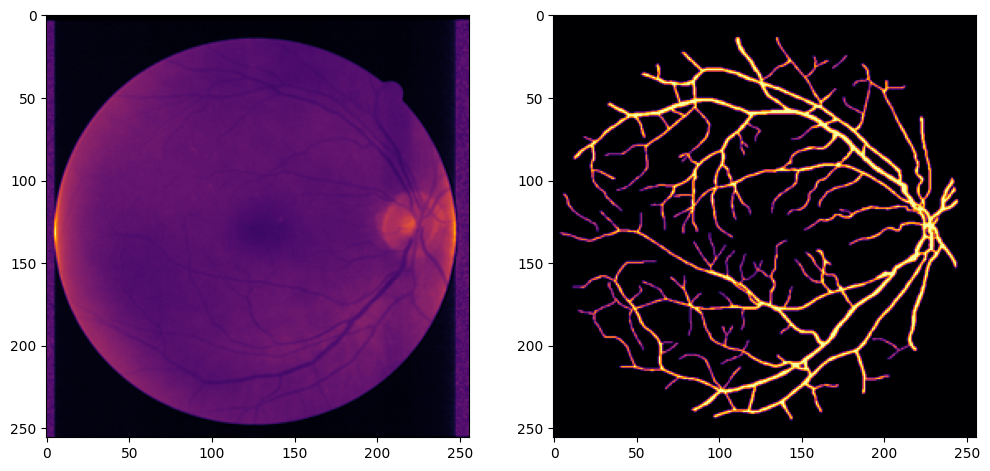

In [ ]:
import random
import numpy as np
image_number = random.randint(0, len(train_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(train_image_dataset[image_number], (256, 256)),cmap="inferno")
plt.subplot(122)
plt.imshow(np.reshape(train_mask_dataset[image_number], (256, 256)),cmap="inferno")
plt.show()

In [ ]:
test_images = os.listdir(image_directory_test)
test_masks = os.listdir(mask_directory_test)

In [ ]:
for i, image_name in enumerate(test_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv.imread(image_directory_test+"/"+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test_image_dataset.append(np.array(image))

In [ ]:
for i, image_name in enumerate(test_masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv.imread(mask_directory_test+"/"+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test_mask_dataset.append(np.array(image))

In [ ]:
#Normalize images
test_image_dataset = np.expand_dims(normalize(np.array(test_image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
test_mask_dataset = np.expand_dims((np.array(test_mask_dataset)),3) /255.

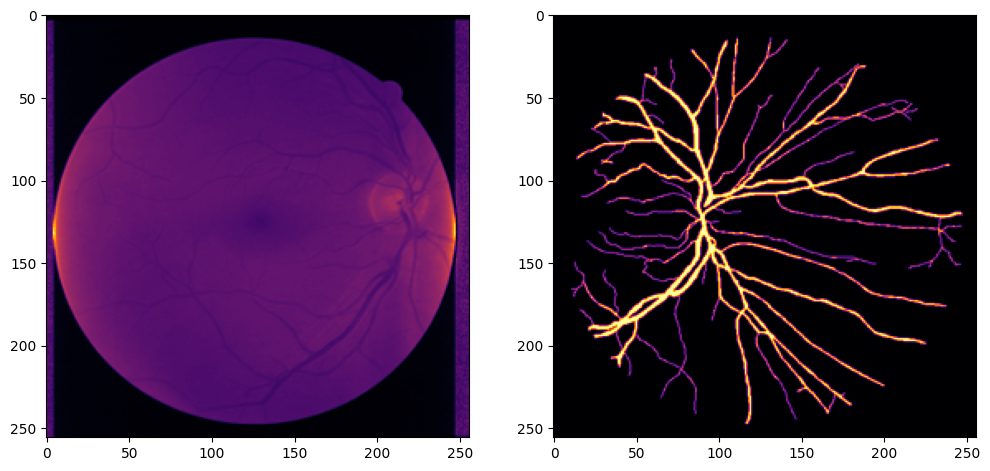

In [ ]:
image_number = random.randint(0, len(test_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(test_image_dataset[image_number], (256, 256)),cmap="inferno")
plt.subplot(122)
plt.imshow(np.reshape(test_mask_dataset[image_number], (256, 256)),cmap="inferno")
plt.show()

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D,  concatenate, Conv2DTranspose, BatchNormalization, Dropout

In [ ]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
IMG_HEIGHT = train_image_dataset.shape[1]
IMG_WIDTH  = train_image_dataset.shape[2]
IMG_CHANNELS = train_image_dataset.shape[3]

In [ ]:
model= simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 16)         160       ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [ ]:
history = model.fit(train_image_dataset, train_mask_dataset,
                    batch_size = 32,
                    verbose=1,
                    epochs=2,
                    validation_data=(test_image_dataset, test_mask_dataset),
                    shuffle=False)

Epoch 1/2
3/3 [==============================] - 80s 22s/step - loss: 0.6457 - accuracy: 0.7499 - val_loss: 0.4121 - val_accuracy: 0.8113
Epoch 2/2
3/3 [==============================] - 71s 23s/step - loss: 0.0683 - accuracy: 0.8125 - val_loss: 14.6545 - val_accuracy: 0.8117
